In [1]:
import matplotlib.pyplot as plt
import numpy as np

def HL(u, kappa):
    delta = (abs(u) <= kappa).astype('float')
    return delta * (u*u / 2) + (1 - delta) * (kappa * (abs(u) - kappa/2))

def rho_tau(u, tau, kappa):
    delta = (u < 0).astype('float')
    if kappa == 0:
#        return abs(tau - delta) * abs(u)
        return (tau - delta) * u
    else:
        return abs(tau - delta) * HL(u, kappa)

In [ ]:
N = 30
xs = np.r_[[-4, -1], np.linspace(-1, 0, N//2), np.linspace(0, 1, N//2), [1, 4]]   # to include 0.0
ys = HL(xs, 1)
ys0 = abs(xs)

plt.plot(xs, ys)
plt.plot(xs, ys0)
plt.legend([r'$\mathcal{L}_1$', r'$|\cdot|$'])
plt.savefig('rho_05.svg', bbox_inches='tight')
plt.show()

In [ ]:
N = 30
xs = np.r_[[-4, -1.2], np.linspace(-1.2, 0, N//2), np.linspace(0, 1.2, N//2), [1.2, 4]]   # to include 0.0
ys = rho_tau(xs, 0.3, 1)
ys0 = rho_tau(xs, 0.3, 0)

plt.plot(xs, ys)
plt.plot(xs, ys0)
plt.legend([r'$\rho_{0.3}^1$', r'$\rho_{0.3}$'])
plt.savefig('rho_03.svg', bbox_inches='tight')
plt.show()

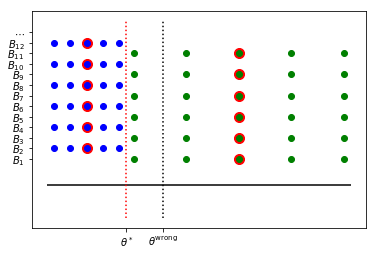

In [131]:
N = 5
theta = 3.0
samples1 = np.linspace(theta - 10.0, theta - 1.0, num=N)
samples2 = np.linspace(theta + 1.0, theta + 30.0, num=N)
zeros = np.zeros_like(samples1)
plt.hlines(0, samples1.min() - 1.0, samples2.max() + 1.0)
vpos = np.linspace(0.2, 1.0, num=6)
vpos1 = vpos + (vpos[1] - vpos[0]) / 2
vpos2 = vpos

vposs = np.sort(np.r_[vpos1, vpos2])
vposs_labels = ['$B_{%d}$' % (i + 1) for i in range(len(vposs))]
vposs = np.append(vposs, 2 * vposs[-1] - vposs[-2])
vposs_labels = np.append(vposs_labels, '$\\cdots$')
plt.yticks(vposs, vposs_labels)

for p1, p2 in zip(vpos1, vpos2):
    plt.scatter(samples1[N//2], p1, c='red', s=100)
    plt.scatter(samples2[N//2], p2, c='red', s=100)
    plt.scatter(samples1, zeros + p1, c='blue')
    plt.scatter(samples2, zeros + p2, c='green')

theta0 = theta
    
# Compute \theta*.
loops = 1000
lr = 0.01
med1 = samples1[N//2]
med2 = samples2[N//2]
for _ in range(loops):
    err = med1 + med2 - 2 * theta
    theta += lr * err
theta_poss = [theta0, theta]
theta_labels = ['$\\theta^*$', '$\\theta^{\\mathrm{wrong}}$']
plt.xticks(theta_poss, theta_labels)
plt.vlines(theta_poss, -0.25, 1.25, linestyle='dotted', colors=['red', 'black'])

plt.savefig('bias_L2.svg', bbox_inches='tight')
plt.show()

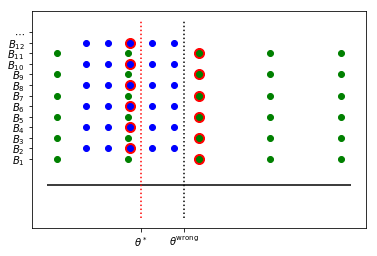

In [166]:
N = 5
theta = 3.0
samples1 = np.linspace(theta - 10.0, theta - 1.0, num=N)
samples2 = np.linspace(theta + 1.0, theta + 30.0, num=N)
samples2 -= 14
zeros = np.zeros_like(samples1)
minx = min(samples1.min(), samples2.min())
maxx = max(samples1.max(), samples2.max())
plt.hlines(0, minx - 1.0, maxx + 1.0)
vpos = np.linspace(0.2, 1.0, num=6)
vpos1 = vpos + (vpos[1] - vpos[0]) / 2
vpos2 = vpos

vposs = np.sort(np.r_[vpos1, vpos2])
vposs_labels = ['$B_{%d}$' % (i + 1) for i in range(len(vposs))]
vposs = np.append(vposs, 2 * vposs[-1] - vposs[-2])
vposs_labels = np.append(vposs_labels, '$\\cdots$')
plt.yticks(vposs, vposs_labels)

for p1, p2 in zip(vpos1, vpos2):
    plt.scatter(samples1[N//2], p1, c='red', s=100)
    plt.scatter(samples2[N//2], p2, c='red', s=100)
    plt.scatter(samples1, zeros + p1, c='blue')
    plt.scatter(samples2, zeros + p2, c='green')

# Compute \theta*.
samples = np.sort(np.r_[samples1, samples2])
midpoint = len(samples) // 2
med = samples[midpoint-1: midpoint+1].mean()

theta_poss = [med, theta]
theta_labels = ['$\\theta^*$', '$\\theta^{\\mathrm{wrong}}$']
plt.xticks(theta_poss, theta_labels)
plt.vlines(theta_poss, -0.25, 1.25, linestyle='dotted', colors=['red', 'black'])

plt.savefig('bias_L1.svg', bbox_inches='tight')
plt.show()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


class Quantiles:
    def __init__(self, taus, tf_graph=None):
        self.taus = taus
        N = len(taus)

        graph = tf_graph or tf.get_default_graph()
        with graph.as_default():
            with tf.variable_scope('quantiles'):
                self.xs = tf.placeholder('float')
                self.theta = tf.get_variable('theta', shape=(N,))
                self.loss = sum(
                    tf.reduce_mean(self._rho_tau(self.xs - self.theta[i],
                                                 taus[i], kappa=0))
                    for i in range(N))
                self.train_step = tf.train.AdamOptimizer(0.05).minimize(
                    self.loss)

    @staticmethod
    def _HL(u, kappa):
        delta = tf.cast(abs(u) <= kappa, 'float')
        return delta * (u * u / 2) + (1 - delta) * (
                kappa * (abs(u) - kappa / 2))

    @staticmethod
    def _rho_tau(u, tau, kappa=1):
        delta = tf.cast(u < 0, 'float')
        if kappa == 0:
            return (tau - delta) * u
        else:
            return abs(tau - delta) * Quantiles._HL(u, kappa)

    def get_quantiles(self, samples, loops):
        with tf.Session() as sess:
            tf.global_variables_initializer().run()
            for _ in range(loops):
                loss, _ = sess.run([self.loss, self.train_step],
                                   {self.xs: samples})
            qs = sess.run(self.theta)
        return qs


class MixtureOfGaussians:
    def __init__(self, pis, mus, sigmas):
        self.pis = pis
        self.mus = mus
        self.sigmas = sigmas

    def draw_samples(self, n):
        samples = np.empty(n)
        for i in range(n):
            idx = np.random.multinomial(1, self.pis).argmax()
            samples[i] = np.random.normal(self.mus[idx], self.sigmas[idx])
        return samples

    def pdf(self, x):
        return np.sum(pi * np.exp(-0.5 * ((x - mu) / s) ** 2) /
                        (s * np.sqrt(2 * pi))
                      for pi, mu, s in zip(self.pis, self.mus, self.sigmas))


tf.reset_default_graph()

MoG = MixtureOfGaussians(pis=[1/3, 1/3, 1/3], mus=[-3, 0, 5], sigmas=[2, 1, 2])
xs = np.linspace(-11, 11, num=200)
ys = MoG.pdf(xs)

N = 10  # num of quantiles
taus = [i / (2 * N) for i in range(0, 2 * N + 1)]
Q = Quantiles(taus)
samples = MoG.draw_samples(10000)
qs = Q.get_quantiles(samples, loops=2000)

plt.plot(xs, ys)

for q in qs[::2]:
    plt.plot([q, q], [0, MoG.pdf(q)], 'black')
plt.plot(qs[1::2], np.zeros_like(qs[1::2]), 'or')

plt.savefig('quantiles.svg', bbox_inches='tight')
plt.show()